# Train CNN with MFCCs


Inspired by https://medium.com/@diego-rios/speech-emotion-recognition-with-convolutional-neural-network-ae5406a1c0f7

MFCC tensors with repetitive padding


Import the necessary libraries


In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchview import draw_graph
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import os
import sys
import numpy as np
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.1+cu118
True


Set the seed for reproducibility


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
MODEL = 'cnn_mfccs_repetitive'

train_csv = '../../../data/mfcc_train_dataset.csv'
test_csv = '../../../data/mfcc_test_dataset.csv'
val_csv = '../../../data/mfcc_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mfcc tensors


In [6]:
from datasets.MfccDataset import MFCCDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Import the model


In [12]:
from CNNMFCCs import CNNMFCCs

model = CNNMFCCs()

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNMFCCs(
  (conv1): Conv1d(40, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=22016, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=9, bias=True)
)

Visualize the model


In [13]:
summary(model, (40, 172))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 172]           1,936
            Conv1d-2              [-1, 32, 172]           1,568
            Conv1d-3              [-1, 64, 172]           6,208
            Conv1d-4             [-1, 128, 172]          24,704
           Dropout-5             [-1, 128, 172]               0
            Linear-6                  [-1, 128]       2,818,176
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
            Linear-9                    [-1, 9]             585
Total params: 2,861,433
Trainable params: 2,861,433
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.49
Params size (MB): 10.92
Estimated Total Size (MB): 11.43
-------------------------------------

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([])

epochs = 100

Execute the training


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/100


Validating: 100%|██████████| 75/75 [00:02<00:00, 36.32it/s, Loss=1.135781168937683, Elapsed=2.2857s, ETA=0.0000s] 

Epoch 1 completed in 11.1268s
Train Loss: 1.4559938976530395 - Train Accuracy: 35.32258429253069
Validation Loss: 1.181783865292867 - Validation Accuracy: 47.10848459265513

Epoch 2/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.32it/s, Loss=1.1118414402008057, Elapsed=1.3463s, ETA=0.0000s]


Epoch 2 completed in 6.4539s
Train Loss: 1.1335317458031495 - Train Accuracy: 48.55385450351643
Validation Loss: 1.0943200333913168 - Validation Accuracy: 49.145208948923596

Epoch 3/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 63.40it/s, Loss=1.1040229797363281, Elapsed=1.3658s, ETA=0.0000s]


Epoch 3 completed in 6.8866s
Train Loss: 1.03619163177606 - Train Accuracy: 52.891160308450736
Validation Loss: 0.9974677268664042 - Validation Accuracy: 56.03630223723089

Epoch 4/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 58.37it/s, Loss=1.362428903579712, Elapsed=1.4743s, ETA=0.0000s] 

Epoch 4 completed in 6.6579s
Train Loss: 0.967318767068014 - Train Accuracy: 56.10004296601162
Validation Loss: 0.9911966180801391 - Validation Accuracy: 52.82819755170958

Epoch 5/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.02it/s, Loss=1.2980492115020752, Elapsed=1.2615s, ETA=0.0000s]


Epoch 5 completed in 6.4973s
Train Loss: 0.9136576401015927 - Train Accuracy: 58.646344496958456
Validation Loss: 0.9458386087417603 - Validation Accuracy: 58.29463908822288

Epoch 6/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 59.08it/s, Loss=1.7964764833450317, Elapsed=1.4576s, ETA=0.0000s]


Epoch 6 completed in 6.5221s
Train Loss: 0.8606793139711281 - Train Accuracy: 60.27905293864906
Validation Loss: 0.9357785034179688 - Validation Accuracy: 59.56099620092866

Epoch 7/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 63.98it/s, Loss=1.1598049402236938, Elapsed=1.3537s, ETA=0.0000s]

Epoch 7 completed in 6.4799s
Train Loss: 0.81058427588099 - Train Accuracy: 62.53363786436309
Validation Loss: 0.9538848225275676 - Validation Accuracy: 59.392148585901225

Epoch 8/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.96it/s, Loss=1.1888285875320435, Elapsed=1.3201s, ETA=0.0000s]


Epoch 8 completed in 6.5543s
Train Loss: 0.7667276836888639 - Train Accuracy: 64.33821035254743
Validation Loss: 0.9395653041203816 - Validation Accuracy: 61.37610806247362

Epoch 9/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 64.71it/s, Loss=1.0783416032791138, Elapsed=1.3494s, ETA=0.0000s]

Epoch 9 completed in 6.5810s
Train Loss: 0.7169954831889599 - Train Accuracy: 66.31916962529115
Validation Loss: 0.9413174637158712 - Validation Accuracy: 60.72182355424229

Epoch 10/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 69.39it/s, Loss=1.2282267808914185, Elapsed=1.2704s, ETA=0.0000s]


Epoch 10 completed in 6.6291s
Train Loss: 0.6761976105801631 - Train Accuracy: 67.73930937789738
Validation Loss: 0.9833914200464885 - Validation Accuracy: 62.66357112705783

Epoch 11/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 66.20it/s, Loss=0.945667564868927, Elapsed=1.3195s, ETA=0.0000s] 

Epoch 11 completed in 6.4821s
Train Loss: 0.6314415053997425 - Train Accuracy: 69.62302978223016
Validation Loss: 1.0071930972735088 - Validation Accuracy: 60.985647952722665

Epoch 12/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.01it/s, Loss=1.0295939445495605, Elapsed=1.3825s, ETA=0.0000s]

Epoch 12 completed in 6.8763s
Train Loss: 0.5962634121062439 - Train Accuracy: 71.08613554645983
Validation Loss: 1.01301513671875 - Validation Accuracy: 61.67159138877163

Epoch 13/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.06it/s, Loss=1.3991143703460693, Elapsed=1.4165s, ETA=0.0000s]


Epoch 13 completed in 6.3496s
Train Loss: 0.5479606545040373 - Train Accuracy: 72.5876845842473
Validation Loss: 1.0526896142959594 - Validation Accuracy: 62.779653862389196

Epoch 14/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 62.50it/s, Loss=0.6369560360908508, Elapsed=1.4070s, ETA=0.0000s]

Epoch 14 completed in 6.4978s
Train Loss: 0.4929191819849731 - Train Accuracy: 75.11815653196446
Validation Loss: 1.1209978032112122 - Validation Accuracy: 61.397214014352045

Epoch 15/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 59.06it/s, Loss=0.6592388153076172, Elapsed=1.4610s, ETA=0.0000s]


Epoch 15 completed in 6.5668s
Train Loss: 0.464858303008052 - Train Accuracy: 76.07697700187693
Validation Loss: 1.1736421902974448 - Validation Accuracy: 64.06711692697341

Epoch 16/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 64.12it/s, Loss=1.1213916540145874, Elapsed=1.3478s, ETA=0.0000s]


Epoch 16 completed in 6.3957s
Train Loss: 0.43503047508655945 - Train Accuracy: 77.43379842156442
Validation Loss: 1.2158732509613037 - Validation Accuracy: 64.60531869987337

Epoch 17/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 65.64it/s, Loss=1.4403727054595947, Elapsed=1.3144s, ETA=0.0000s]

Epoch 17 completed in 6.2979s
Train Loss: 0.42093097741548724 - Train Accuracy: 78.28181180886908
Validation Loss: 1.2746301341056823 - Validation Accuracy: 62.99071338117349

Epoch 18/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.50it/s, Loss=1.0274765491485596, Elapsed=1.3198s, ETA=0.0000s]

Epoch 18 completed in 6.6299s
Train Loss: 0.3786021520119871 - Train Accuracy: 80.007236380905
Validation Loss: 1.3138602336247762 - Validation Accuracy: 63.59223300970874

Epoch 19/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.96it/s, Loss=2.1200432777404785, Elapsed=1.2829s, ETA=0.0000s]

Epoch 19 completed in 6.5048s
Train Loss: 0.34079287214086235 - Train Accuracy: 81.96105922525497
Validation Loss: 1.4383714373906453 - Validation Accuracy: 64.3520472773322

Epoch 20/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.24it/s, Loss=0.9408850073814392, Elapsed=1.3475s, ETA=0.0000s]

Epoch 20 completed in 6.6090s
Train Loss: 0.3244130306936413 - Train Accuracy: 82.56032201895027
Validation Loss: 1.470443905989329 - Validation Accuracy: 64.22541156606162

Epoch 21/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.36it/s, Loss=1.1223392486572266, Elapsed=1.3159s, ETA=0.0000s]

Epoch 21 completed in 6.2202s
Train Loss: 0.31255628078142345 - Train Accuracy: 83.47843784627213
Validation Loss: 1.609883378346761 - Validation Accuracy: 63.48670325031659

Epoch 22/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 59.73it/s, Loss=0.7944998145103455, Elapsed=1.4570s, ETA=0.0000s]

Epoch 22 completed in 6.5396s
Train Loss: 0.29069847505905727 - Train Accuracy: 84.31062165034712
Validation Loss: 1.5656994978586833 - Validation Accuracy: 64.58421274799493

Epoch 23/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.69it/s, Loss=0.7884472012519836, Elapsed=1.4252s, ETA=0.0000s]

Epoch 23 completed in 6.5350s
Train Loss: 0.2653048752532529 - Train Accuracy: 85.69684086746116
Validation Loss: 1.613865479628245 - Validation Accuracy: 64.04601097509499

Epoch 24/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.32it/s, Loss=1.151879906654358, Elapsed=1.2571s, ETA=0.0000s] 

Epoch 24 completed in 6.2318s
Train Loss: 0.27138842353758785 - Train Accuracy: 85.64030664164085
Validation Loss: 1.6209647878011069 - Validation Accuracy: 64.39425918108907

Epoch 25/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.09it/s, Loss=0.9353095889091492, Elapsed=1.3565s, ETA=0.0000s]


Epoch 25 completed in 6.5596s
Train Loss: 0.23919089584250672 - Train Accuracy: 86.9745143710002
Validation Loss: 1.7759441097577413 - Validation Accuracy: 65.38623891937526

Epoch 26/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 59.35it/s, Loss=1.7260046005249023, Elapsed=1.4827s, ETA=0.0000s]

Epoch 26 completed in 6.9471s
Train Loss: 0.2548384006657352 - Train Accuracy: 86.77325252707989
Validation Loss: 1.8416813786824544 - Validation Accuracy: 64.06711692697341

Epoch 27/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.52it/s, Loss=1.4066733121871948, Elapsed=1.3164s, ETA=0.0000s]

Epoch 27 completed in 6.3855s
Train Loss: 0.22197556196351273 - Train Accuracy: 88.11424436353768
Validation Loss: 1.7818767889340719 - Validation Accuracy: 64.8480371464753

Epoch 28/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.52it/s, Loss=1.5415260791778564, Elapsed=1.3701s, ETA=0.0000s]

Epoch 28 completed in 6.5061s
Train Loss: 0.2055887248087136 - Train Accuracy: 88.9509509056783
Validation Loss: 1.9194207652409871 - Validation Accuracy: 63.951034191642044

Epoch 29/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.37it/s, Loss=2.4519035816192627, Elapsed=1.4348s, ETA=0.0000s]

Epoch 29 completed in 6.5833s
Train Loss: 0.2040032361111889 - Train Accuracy: 89.36704280771579
Validation Loss: 1.8031035566329956 - Validation Accuracy: 63.845504432249896

Epoch 30/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.98it/s, Loss=1.0311740636825562, Elapsed=1.3010s, ETA=0.0000s]

Epoch 30 completed in 6.4209s
Train Loss: 0.20726189267084089 - Train Accuracy: 89.32859953415799
Validation Loss: 2.0293801975250245 - Validation Accuracy: 64.15154073448713

Epoch 31/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.64it/s, Loss=1.745314121246338, Elapsed=1.3348s, ETA=0.0000s] 

Epoch 31 completed in 6.2347s
Train Loss: 0.1904739287245825 - Train Accuracy: 90.07485131498609
Validation Loss: 2.0457053558031717 - Validation Accuracy: 64.5525538201773

Epoch 32/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.57it/s, Loss=1.456536889076233, Elapsed=1.2426s, ETA=0.0000s] 

Epoch 32 completed in 6.2028s
Train Loss: 0.19204807973256863 - Train Accuracy: 89.99118066077203
Validation Loss: 2.016789623896281 - Validation Accuracy: 64.71084845926552

Epoch 33/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.09it/s, Loss=2.7116923332214355, Elapsed=1.3125s, ETA=0.0000s]

Epoch 33 completed in 6.5514s
Train Loss: 0.16361339926461263 - Train Accuracy: 91.3253883901314
Validation Loss: 2.0294287729263307 - Validation Accuracy: 64.78471929084002

Epoch 34/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.82it/s, Loss=0.9353762865066528, Elapsed=1.3519s, ETA=0.0000s]

Epoch 34 completed in 6.3000s
Train Loss: 0.16014098583833675 - Train Accuracy: 91.62388910246263
Validation Loss: 2.1083830308914187 - Validation Accuracy: 64.68974250738708

Epoch 35/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.38it/s, Loss=2.2027697563171387, Elapsed=1.3304s, ETA=0.0000s]

Epoch 35 completed in 6.2764s
Train Loss: 0.16815520784241617 - Train Accuracy: 91.46107053210014
Validation Loss: 2.1004625384012856 - Validation Accuracy: 63.011819333051925

Epoch 36/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 69.25it/s, Loss=3.6948025226593018, Elapsed=1.2952s, ETA=0.0000s]

Epoch 36 completed in 6.2556s
Train Loss: 0.16312675791754888 - Train Accuracy: 91.64424142375795
Validation Loss: 2.2726110855738324 - Validation Accuracy: 64.79527226677924

Epoch 37/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.79it/s, Loss=3.7297377586364746, Elapsed=1.3254s, ETA=0.0000s]

Epoch 37 completed in 6.2627s
Train Loss: 0.1466491484120919 - Train Accuracy: 92.44250469234075
Validation Loss: 2.214360845883687 - Validation Accuracy: 64.53144786829887

Epoch 38/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.67it/s, Loss=4.820598602294922, Elapsed=1.2660s, ETA=0.0000s] 

Epoch 38 completed in 6.4515s
Train Loss: 0.1564657068515272 - Train Accuracy: 92.19375409873138
Validation Loss: 2.0222947883605955 - Validation Accuracy: 63.09624314056565

Epoch 39/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.49it/s, Loss=2.0459444522857666, Elapsed=1.3523s, ETA=0.0000s]

Epoch 39 completed in 6.6466s
Train Loss: 0.13069597564939128 - Train Accuracy: 93.22493837769386
Validation Loss: 2.1633057594299316 - Validation Accuracy: 64.489235964542

Epoch 40/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.23it/s, Loss=2.274204730987549, Elapsed=1.3226s, ETA=0.0000s] 

Epoch 40 completed in 6.5709s
Train Loss: 0.14381330364486042 - Train Accuracy: 92.7817100472626
Validation Loss: 2.2225938002268473 - Validation Accuracy: 64.56310679611651

Epoch 41/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.66it/s, Loss=3.4200022220611572, Elapsed=1.4013s, ETA=0.0000s]

Epoch 41 completed in 6.5281s
Train Loss: 0.12325728330438192 - Train Accuracy: 93.68399629135479
Validation Loss: 2.271317598025004 - Validation Accuracy: 64.60531869987337

Epoch 42/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.84it/s, Loss=3.053920030593872, Elapsed=1.3195s, ETA=0.0000s] 


Epoch 42 completed in 6.7501s
Train Loss: 0.12249826243674825 - Train Accuracy: 93.92822414689853
Validation Loss: 2.3897164980570476 - Validation Accuracy: 65.29126213592234

Epoch 43/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 63.58it/s, Loss=3.417585849761963, Elapsed=1.3920s, ETA=0.0000s] 

Epoch 43 completed in 6.4563s
Train Loss: 0.1470047482585459 - Train Accuracy: 92.82919879695167
Validation Loss: 2.271383163134257 - Validation Accuracy: 64.09877585479104

Epoch 44/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.64it/s, Loss=4.14176082611084, Elapsed=1.4405s, ETA=0.0000s]  

Epoch 44 completed in 6.4937s
Train Loss: 0.13124124682104657 - Train Accuracy: 93.72922367201103
Validation Loss: 2.3443739064534506 - Validation Accuracy: 64.14098775854791

Epoch 45/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.06it/s, Loss=3.950727939605713, Elapsed=1.3464s, ETA=0.0000s] 


Epoch 45 completed in 6.6697s
Train Loss: 0.11846869399049723 - Train Accuracy: 94.10687230049072
Validation Loss: 2.3872008339564004 - Validation Accuracy: 63.5605740818911

Epoch 46/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 66.08it/s, Loss=3.4800221920013428, Elapsed=1.3336s, ETA=0.0000s]

Epoch 46 completed in 6.1151s
Train Loss: 0.11649049118139668 - Train Accuracy: 94.3578842631329
Validation Loss: 2.461715998649597 - Validation Accuracy: 64.96411988180667

Epoch 47/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.40it/s, Loss=4.421070098876953, Elapsed=1.3642s, ETA=0.0000s] 

Epoch 47 completed in 7.1228s
Train Loss: 0.11468309484357607 - Train Accuracy: 94.30587277537822
Validation Loss: 2.499278462727865 - Validation Accuracy: 65.14352047277332

Epoch 48/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.08it/s, Loss=6.097705364227295, Elapsed=1.4094s, ETA=0.0000s] 

Epoch 48 completed in 6.8168s
Train Loss: 0.12033868427630622 - Train Accuracy: 94.3036114063454
Validation Loss: 2.5284782679875693 - Validation Accuracy: 64.82693119459688

Epoch 49/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.03it/s, Loss=4.285615921020508, Elapsed=1.3258s, ETA=0.0000s] 

Epoch 49 completed in 6.6695s
Train Loss: 0.10677583898939838 - Train Accuracy: 94.88026050971257
Validation Loss: 2.4263857968648277 - Validation Accuracy: 63.72942169691853

Epoch 50/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.36it/s, Loss=3.6846325397491455, Elapsed=1.3896s, ETA=0.0000s]

Epoch 50 completed in 6.4032s
Train Loss: 0.12224234336438035 - Train Accuracy: 94.16792926437665
Validation Loss: 2.2344883553187054 - Validation Accuracy: 63.30730265934994

Epoch 51/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.67it/s, Loss=3.7755258083343506, Elapsed=1.3568s, ETA=0.0000s]

Epoch 51 completed in 6.7425s
Train Loss: 0.12095337755159835 - Train Accuracy: 94.15662241921258
Validation Loss: 2.362258578936259 - Validation Accuracy: 63.9932460953989

Epoch 52/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.92it/s, Loss=4.106874465942383, Elapsed=1.3840s, ETA=0.0000s] 

Epoch 52 completed in 6.5377s
Train Loss: 0.10959307273386876 - Train Accuracy: 94.76945342710476
Validation Loss: 2.4286433362960818 - Validation Accuracy: 64.37315322921063

Epoch 53/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.21it/s, Loss=1.8527569770812988, Elapsed=1.2897s, ETA=0.0000s]

Epoch 53 completed in 6.6158s
Train Loss: 0.10537632502012514 - Train Accuracy: 94.94131747359852
Validation Loss: 2.442545895576477 - Validation Accuracy: 64.29928239763613

Epoch 54/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.11it/s, Loss=3.6273605823516846, Elapsed=1.3584s, ETA=0.0000s]

Epoch 54 completed in 6.4068s
Train Loss: 0.1042471477180461 - Train Accuracy: 95.04534044910788
Validation Loss: 2.4837542804082235 - Validation Accuracy: 64.49978894048122

Epoch 55/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.77it/s, Loss=3.07120943069458, Elapsed=1.3784s, ETA=0.0000s]  

Epoch 55 completed in 6.3349s
Train Loss: 0.11014817573259332 - Train Accuracy: 94.9571470568282
Validation Loss: 2.472821807861328 - Validation Accuracy: 64.18319966230477

Epoch 56/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.71it/s, Loss=4.176418304443359, Elapsed=1.3236s, ETA=0.0000s] 

Epoch 56 completed in 6.8710s
Train Loss: 0.10183272050489063 - Train Accuracy: 95.11092015105945
Validation Loss: 2.3355115095774335 - Validation Accuracy: 64.51034191642043

Epoch 57/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 69.42it/s, Loss=2.8293139934539795, Elapsed=1.2684s, ETA=0.0000s]

Epoch 57 completed in 6.5425s
Train Loss: 0.09391864653504481 - Train Accuracy: 95.6446032428032
Validation Loss: 2.4851284233729043 - Validation Accuracy: 64.11988180666948

Epoch 58/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.87it/s, Loss=6.961751937866211, Elapsed=1.3390s, ETA=0.0000s] 

Epoch 58 completed in 6.4235s
Train Loss: 0.09484588023748873 - Train Accuracy: 95.52475068406413
Validation Loss: 2.458558150927226 - Validation Accuracy: 63.82439848037147

Epoch 59/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.73it/s, Loss=4.508962154388428, Elapsed=1.3633s, ETA=0.0000s] 

Epoch 59 completed in 6.5598s
Train Loss: 0.0985115668440313 - Train Accuracy: 95.51118246986726
Validation Loss: 2.4176713832219443 - Validation Accuracy: 64.36260025327142

Epoch 60/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 54.78it/s, Loss=4.294672966003418, Elapsed=1.5670s, ETA=0.0000s] 

Epoch 60 completed in 6.7377s
Train Loss: 0.07979292656440352 - Train Accuracy: 96.17602496551412
Validation Loss: 2.536584040323893 - Validation Accuracy: 64.47868298860278

Epoch 61/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.70it/s, Loss=4.272761344909668, Elapsed=1.3178s, ETA=0.0000s] 

Epoch 61 completed in 6.8266s
Train Loss: 0.0848046003361744 - Train Accuracy: 95.98154722869225
Validation Loss: 2.6013210074106854 - Validation Accuracy: 63.63444491346559

Epoch 62/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.50it/s, Loss=4.54522180557251, Elapsed=1.3575s, ETA=0.0000s]  

Epoch 62 completed in 6.6168s
Train Loss: 0.10780894139921562 - Train Accuracy: 95.0837837226657
Validation Loss: 2.472666309674581 - Validation Accuracy: 64.62642465175179

Epoch 63/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.58it/s, Loss=5.094620704650879, Elapsed=1.3199s, ETA=0.0000s] 


Epoch 63 completed in 6.3842s
Train Loss: 0.09675382418999437 - Train Accuracy: 95.71470568282038
Validation Loss: 2.5121185477574666 - Validation Accuracy: 64.86914309835373

Epoch 64/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 65.19it/s, Loss=3.8613035678863525, Elapsed=1.3379s, ETA=0.0000s]

Epoch 64 completed in 6.4162s
Train Loss: 0.08816559742490164 - Train Accuracy: 95.96345627642975
Validation Loss: 2.4323487122853598 - Validation Accuracy: 64.5525538201773

Epoch 65/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.61it/s, Loss=3.3861629962921143, Elapsed=1.3724s, ETA=0.0000s]

Epoch 65 completed in 6.5206s
Train Loss: 0.09551290583102345 - Train Accuracy: 95.73505800411569
Validation Loss: 2.5026355282465618 - Validation Accuracy: 64.62642465175179

Epoch 66/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.81it/s, Loss=5.018571376800537, Elapsed=1.3718s, ETA=0.0000s] 


Epoch 66 completed in 6.5404s
Train Loss: 0.08518799267859989 - Train Accuracy: 96.13079758485787
Validation Loss: 2.5939431683222454 - Validation Accuracy: 64.5525538201773

Epoch 67/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 64.01it/s, Loss=5.265042781829834, Elapsed=1.3646s, ETA=0.0000s] 

Epoch 67 completed in 6.5056s
Train Loss: 0.08362376793271545 - Train Accuracy: 96.16697948938288
Validation Loss: 2.5344547780354816 - Validation Accuracy: 64.5525538201773

Epoch 68/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.82it/s, Loss=5.667969226837158, Elapsed=1.3062s, ETA=0.0000s] 

Epoch 68 completed in 6.3033s
Train Loss: 0.10213164801068733 - Train Accuracy: 95.45012550598132
Validation Loss: 2.4533495887120567 - Validation Accuracy: 63.7083157450401

Epoch 69/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.76it/s, Loss=5.552651882171631, Elapsed=1.3129s, ETA=0.0000s] 

Epoch 69 completed in 6.5186s
Train Loss: 0.07600037186713404 - Train Accuracy: 96.42929829718912
Validation Loss: 2.668995606104533 - Validation Accuracy: 62.88518362178134

Epoch 70/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.11it/s, Loss=4.04191780090332, Elapsed=1.2934s, ETA=0.0000s]  

Epoch 70 completed in 6.3322s
Train Loss: 0.0838277523831136 - Train Accuracy: 96.1918545487438
Validation Loss: 2.6401524925231934 - Validation Accuracy: 63.90882228788518

Epoch 71/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.26it/s, Loss=4.87468957901001, Elapsed=1.3443s, ETA=0.0000s]  

Epoch 71 completed in 6.4175s
Train Loss: 0.0766198709499457 - Train Accuracy: 96.46774157074694
Validation Loss: 2.560836238861084 - Validation Accuracy: 64.25707049387927

Epoch 72/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.37it/s, Loss=6.080685138702393, Elapsed=1.3221s, ETA=0.0000s] 

Epoch 72 completed in 6.3092s
Train Loss: 0.07483070641971393 - Train Accuracy: 96.51070758237037
Validation Loss: 2.6278465366363526 - Validation Accuracy: 65.16462642465174

Epoch 73/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.58it/s, Loss=2.4523775577545166, Elapsed=1.3306s, ETA=0.0000s]

Epoch 73 completed in 6.4402s
Train Loss: 0.0790868590725855 - Train Accuracy: 96.48583252300944
Validation Loss: 2.4754654852549236 - Validation Accuracy: 64.04601097509499

Epoch 74/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.66it/s, Loss=6.322121620178223, Elapsed=1.2705s, ETA=0.0000s] 

Epoch 74 completed in 6.3392s
Train Loss: 0.08646089365878115 - Train Accuracy: 96.1918545487438
Validation Loss: 2.5808257087071738 - Validation Accuracy: 63.98269311945969

Epoch 75/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.56it/s, Loss=3.165070056915283, Elapsed=1.3598s, ETA=0.0000s] 

Epoch 75 completed in 6.4266s
Train Loss: 0.08391849747239855 - Train Accuracy: 96.17828633454694
Validation Loss: 2.507411894798279 - Validation Accuracy: 64.46813001266356

Epoch 76/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.06it/s, Loss=4.1088762283325195, Elapsed=1.3886s, ETA=0.0000s]

Epoch 76 completed in 6.5125s
Train Loss: 0.07945481167750897 - Train Accuracy: 96.41799145202505
Validation Loss: 2.621776229540507 - Validation Accuracy: 64.43647108484592

Epoch 77/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.89it/s, Loss=5.82493257522583, Elapsed=1.3575s, ETA=0.0000s]  

Epoch 77 completed in 6.6698s
Train Loss: 0.07728323705677438 - Train Accuracy: 96.6984012120938
Validation Loss: 2.6787526575724283 - Validation Accuracy: 64.54200084423807

Epoch 78/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.92it/s, Loss=6.504146575927734, Elapsed=1.3234s, ETA=0.0000s] 

Epoch 78 completed in 6.3075s
Train Loss: 0.07442065496859006 - Train Accuracy: 96.54688948689537
Validation Loss: 2.651415901184082 - Validation Accuracy: 64.9852258336851

Epoch 79/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.40it/s, Loss=5.58221435546875, Elapsed=1.3329s, ETA=0.0000s]  

Epoch 79 completed in 6.5976s
Train Loss: 0.08973299227708767 - Train Accuracy: 96.01772913321724
Validation Loss: 2.6758697684605917 - Validation Accuracy: 64.09877585479104

Epoch 80/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.81it/s, Loss=5.13857889175415, Elapsed=1.3683s, ETA=0.0000s]  

Epoch 80 completed in 6.5318s
Train Loss: 0.07157266538353324 - Train Accuracy: 96.78433323534068
Validation Loss: 2.668833715120951 - Validation Accuracy: 64.25707049387927

Epoch 81/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.93it/s, Loss=5.883780002593994, Elapsed=1.3886s, ETA=0.0000s] 

Epoch 81 completed in 6.5671s
Train Loss: 0.08115208343834202 - Train Accuracy: 96.41346871395943
Validation Loss: 2.640466556549072 - Validation Accuracy: 64.95356690586746

Epoch 82/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 59.62it/s, Loss=1.9245951175689697, Elapsed=1.4747s, ETA=0.0000s]

Epoch 82 completed in 7.1549s
Train Loss: 0.07464544467407284 - Train Accuracy: 96.61020781981412
Validation Loss: 2.5779680585861207 - Validation Accuracy: 63.5605740818911

Epoch 83/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.11it/s, Loss=7.006074905395508, Elapsed=1.4002s, ETA=0.0000s] 

Epoch 83 completed in 6.7791s
Train Loss: 0.07749920464093889 - Train Accuracy: 96.68483299789693
Validation Loss: 2.555211429595947 - Validation Accuracy: 64.32038834951457

Epoch 84/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.00it/s, Loss=4.359521865844727, Elapsed=1.3441s, ETA=0.0000s] 

Epoch 84 completed in 6.4652s
Train Loss: 0.06575816260876856 - Train Accuracy: 96.98107234119536
Validation Loss: 2.6426789553960166 - Validation Accuracy: 64.53144786829887

Epoch 85/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 72.13it/s, Loss=4.782281875610352, Elapsed=1.2630s, ETA=0.0000s] 

Epoch 85 completed in 6.5658s
Train Loss: 0.06963192134008156 - Train Accuracy: 96.90418579407974
Validation Loss: 2.665579702059428 - Validation Accuracy: 64.58421274799493

Epoch 86/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 58.16it/s, Loss=4.443411827087402, Elapsed=1.4738s, ETA=0.0000s] 

Epoch 86 completed in 6.7094s
Train Loss: 0.06504689056474737 - Train Accuracy: 96.89514031794847
Validation Loss: 2.686173437436422 - Validation Accuracy: 64.87969607429295

Epoch 87/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 71.13it/s, Loss=8.083123207092285, Elapsed=1.2676s, ETA=0.0000s] 

Epoch 87 completed in 6.3389s
Train Loss: 0.06459604060503445 - Train Accuracy: 97.05795888831098
Validation Loss: 2.6487473996480304 - Validation Accuracy: 63.96158716758126

Epoch 88/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.23it/s, Loss=7.550106048583984, Elapsed=1.3228s, ETA=0.0000s] 

Epoch 88 completed in 6.9172s
Train Loss: 0.06926095320687042 - Train Accuracy: 96.94262906763754
Validation Loss: 2.729250604311625 - Validation Accuracy: 63.98269311945969

Epoch 89/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.95it/s, Loss=11.23299789428711, Elapsed=1.4002s, ETA=0.0000s] 

Epoch 89 completed in 6.8119s
Train Loss: 0.07135717178199634 - Train Accuracy: 96.96298138893286
Validation Loss: 2.608603638013204 - Validation Accuracy: 64.61587167581257

Epoch 90/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.37it/s, Loss=7.5831074714660645, Elapsed=1.3201s, ETA=0.0000s]

Epoch 90 completed in 6.8416s
Train Loss: 0.06637410028175467 - Train Accuracy: 97.11449311413129
Validation Loss: 2.665696913401286 - Validation Accuracy: 64.22541156606162

Epoch 91/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 58.19it/s, Loss=8.81668758392334, Elapsed=1.4768s, ETA=0.0000s]  

Epoch 91 completed in 6.8657s
Train Loss: 0.0714085892090477 - Train Accuracy: 96.86574252052192
Validation Loss: 2.7219506390889485 - Validation Accuracy: 64.83748417053609

Epoch 92/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.01it/s, Loss=10.371847152709961, Elapsed=1.2720s, ETA=0.0000s]

Epoch 92 completed in 7.1313s
Train Loss: 0.0684977384025737 - Train Accuracy: 96.94715180570317
Validation Loss: 2.641517712275187 - Validation Accuracy: 63.81384550443225

Epoch 93/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.61it/s, Loss=6.498278617858887, Elapsed=1.3889s, ETA=0.0000s] 

Epoch 93 completed in 6.9026s
Train Loss: 0.062041945787781924 - Train Accuracy: 97.25243662513286
Validation Loss: 2.9070668538411457 - Validation Accuracy: 64.40481215702827

Epoch 94/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 69.85it/s, Loss=4.537567138671875, Elapsed=1.2690s, ETA=0.0000s] 

Epoch 94 completed in 6.9608s
Train Loss: 0.06811327236634544 - Train Accuracy: 97.02403835281879
Validation Loss: 2.8693343512217204 - Validation Accuracy: 64.27817644575771

Epoch 95/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.16it/s, Loss=4.417304039001465, Elapsed=1.4086s, ETA=0.0000s] 

Epoch 95 completed in 7.1350s
Train Loss: 0.05693886979924504 - Train Accuracy: 97.41977793356098
Validation Loss: 2.945802238782247 - Validation Accuracy: 64.36260025327142

Epoch 96/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.19it/s, Loss=6.323261260986328, Elapsed=1.3604s, ETA=0.0000s] 

Epoch 96 completed in 6.7600s
Train Loss: 0.05600346892404591 - Train Accuracy: 97.37455055290472
Validation Loss: 2.905593695640564 - Validation Accuracy: 64.94301392992824

Epoch 97/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 69.31it/s, Loss=5.748837947845459, Elapsed=1.2966s, ETA=0.0000s] 

Epoch 97 completed in 6.9979s
Train Loss: 0.061384383663050615 - Train Accuracy: 97.22530019673911
Validation Loss: 2.9204746802647907 - Validation Accuracy: 64.90080202617138

Epoch 98/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 71.06it/s, Loss=7.444106578826904, Elapsed=1.2660s, ETA=0.0000s] 

Epoch 98 completed in 7.0751s
Train Loss: 0.07407757883078575 - Train Accuracy: 96.86348115148911
Validation Loss: 2.827933429082235 - Validation Accuracy: 65.12241452089489

Epoch 99/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.16it/s, Loss=2.9259462356567383, Elapsed=1.3004s, ETA=0.0000s]

Epoch 99 completed in 6.8344s
Train Loss: 0.06678626339914913 - Train Accuracy: 97.05343615024535
Validation Loss: 2.7283115084966023 - Validation Accuracy: 64.11988180666948

Epoch 100/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.16it/s, Loss=3.746809720993042, Elapsed=1.3552s, ETA=0.0000s] 


Epoch 100 completed in 6.9696s
Train Loss: 0.06869648369109915 - Train Accuracy: 96.96072001990005
Validation Loss: 2.8279938220977785 - Validation Accuracy: 65.00633178556353



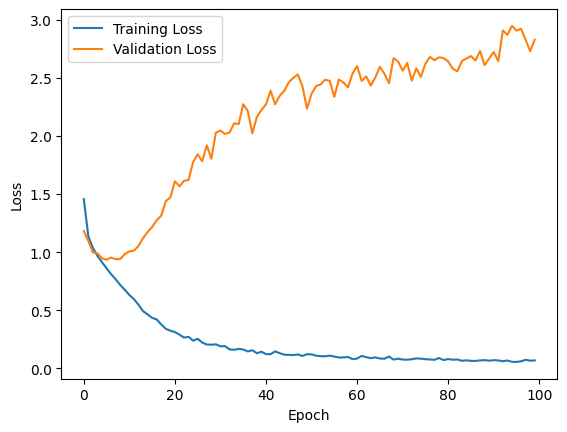

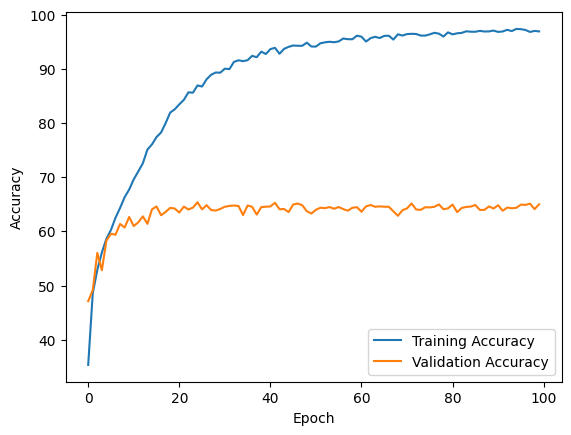

In [15]:
trainset = MFCCDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MFCCDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MFCCDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [17]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:02<00:00, 34.85it/s]


Test Accuracy: 0.6361
Test Precision: 0.6404
Test Recall: 0.6361
Test F1-score: 0.6358

              precision    recall  f1-score   support

       Anger       0.61      0.71      0.65       916
       Bored       0.68      0.77      0.72      1098
     Disgust       0.43      0.58      0.50       291
        Fear       0.46      0.50      0.48       308
       Happy       0.63      0.52      0.57      1914
     Neutral       0.59      0.62      0.60      2226
    Question       0.75      0.73      0.74      1139
         Sad       0.69      0.65      0.67       857
    Surprise       0.73      0.63      0.67       728

    accuracy                           0.64      9477
   macro avg       0.62      0.63      0.62      9477
weighted avg       0.64      0.64      0.64      9477



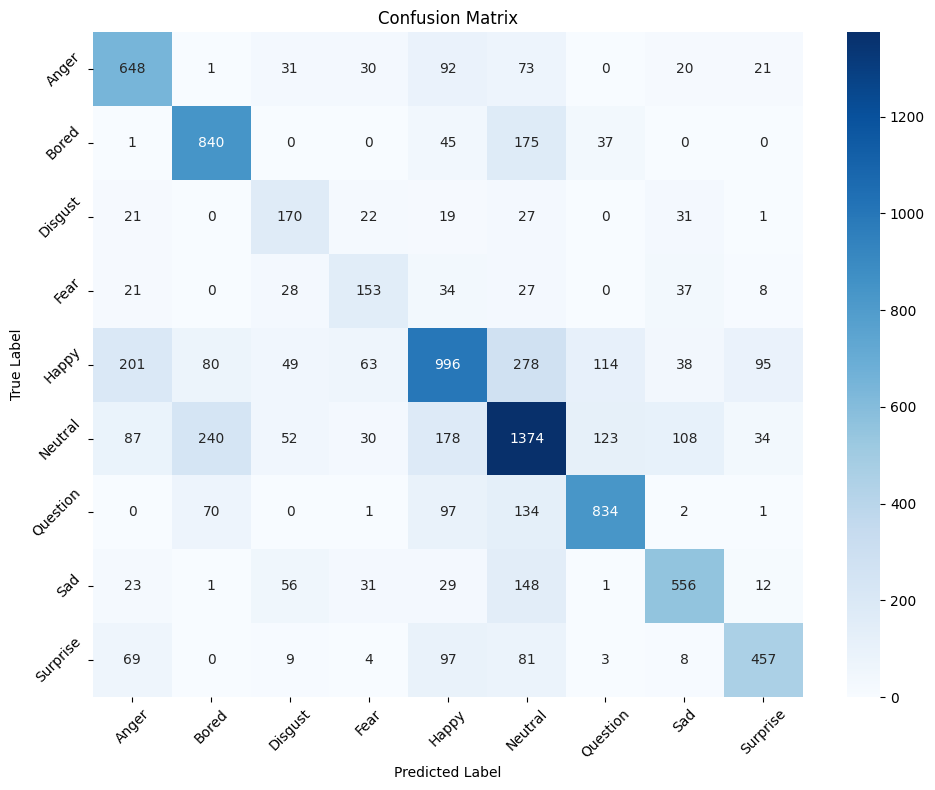

In [19]:
# Load and get predictions from the bets model
best_model_path = f'best_{MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)